# Visualize and optimize

We start by importing the data and then view a sample just to make sure it's all there. Our weapon of choice is numpy. The data consists of four columns: Subject ID, actigraph hours, self-report hours, and a difference score. Our variables of interest are the actigraph hours and self-report hours. Both these variables measure the time asleep in hours among 197 individuals, as measured by actigraph and a self-report questionnaire (PSQI) respectively. 

In [51]:
import numpy as np
np.set_printoptions(precision=2, suppress=True) # display 2 d.p.
data = np.genfromtxt('data.csv', delimiter=',', skip_header=1)
print("We have {} rows in the data set. e.g.,:".format(data.shape[0]))
data[60:80,:].view()  # view a sample of records (lines 60 to 80)

We have 197 rows in the data set. e.g.,:


array([[ 33751.  ,      7.69,      8.83,      1.14],
       [ 33791.  ,      6.97,      7.83,      0.86],
       [ 34241.  ,      8.56,      8.5 ,     -0.06],
       [ 34242.  ,      8.36,      9.92,      1.56],
       [ 34532.  ,      6.31,      6.33,      0.02],
       [ 35781.  ,      7.18,      8.33,      1.15],
       [ 35981.  ,      5.77,      4.75,     -1.02],
       [ 37451.  ,      7.13,      9.25,      2.13],
       [ 37452.  ,      6.29,      8.33,      2.04],
       [ 37571.  ,      6.22,       nan,     -1.72],
       [ 37572.  ,      5.15,       nan,     -1.65],
       [ 38101.  ,      9.43,     10.33,      0.9 ],
       [ 38262.  ,      6.55,      4.5 ,     -2.05],
       [ 38501.  ,      7.1 ,      6.25,     -0.85],
       [ 38512.  ,      6.98,      4.42,     -2.56],
       [ 39331.  ,      7.04,      7.  ,     -0.04],
       [ 39332.  ,      6.03,      6.67,      0.64],
       [ 40391.  ,      6.66,      4.67,     -1.99],
       [ 40392.  ,      6.1 ,      5.83,     -

Missing data is indicated by nan. We will have to remove those rows.

In [52]:
data = data[~np.isnan(data).any(axis=1)]
print("NaNs removed. There are {} rows in the data set".format(data.shape[0]))

NaNs removed. There are 193 rows in the data set


Differences exist between our two variables of interest. To view these differences in more detail, we can use the magic of Seaborn (thanks Sam!). A simple scatterplot will show us the variables covary substantially (~25%), but not perfectly (i.e., r = 0.51)

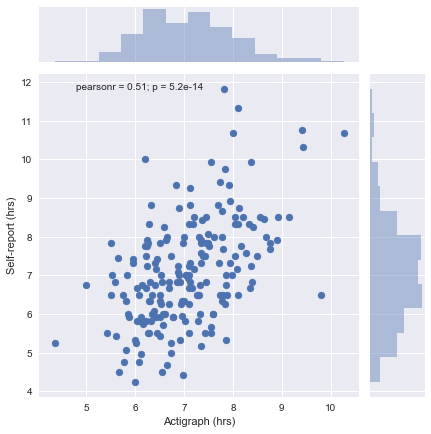

In [53]:
from scipy import stats, integrate
import matplotlib.pyplot as pl
import seaborn as ss
%matplotlib inline

x = data[:,1] # Actigraph hrs
y = data[:,2] # Self-report hrs

ss.set(color_codes=True)
ss.jointplot(x, y).set_axis_labels("Actigraph (hrs)", "Self-report (hrs)")
#ss.jointplot(x, y, kind="kde");

In [54]:
# Add a z-score transform
x_z = stats.zscore(x) # Actigraph z-scores
y_z = stats.zscore(y) # Self-report z-scores
d = np.asarray([x_z,y_z]).T # create an array
d.shape

(193, 2)

Our aim is to divide the data into tripartite divisions which result in three equivalent (but not equal) proportions in both data sets. In other words, we aim to minimize the 'error' between data sets by carefully selecting our divsion thresholds.

The strategy is to build a cost function to express the difference in proportions between the two datasets obtained with any set of division thresholds. This is the 'error' or 'cost', hence the name **split_cost**.

The **split_cost** function includes an option to set a minimum percentage in the top and bottom divisions (**minpercent**). And our default dataset (**d**) will be the z-score transformed variables rather than raw hours. This means the threshold (**params**) will be given in z-score units rather than hours (e.g., -1 and +1 z-score units)

In [55]:
def split_cost(params, minpercent=10, array=d): # array=[actHrs, psqiHrs], params=[lo, hi]
    
    a = array[:,0] 
    b = array[:,1]
    lo, hi = params # threshold to test
    bottomPercenta = np.percentile(a, minpercent)
    bottomPercentb = np.percentile(b, minpercent)
    topPercenta = np.percentile(a, 100-minpercent)
    topPercentb = np.percentile(b, 100-minpercent)
    lb = max(bottomPercenta, bottomPercentb)
    ub = min(topPercenta, topPercentb)
    
    # Enforce restrictions to ensure some membership in each division
    if lo < lb:
        lo = lb
    if hi > ub:
        hi = ub
    
    loErr = abs(sum(a <= lo) - sum(b <= lo))
    hiErr = abs(sum(a >= hi) - sum(b >= hi))
    sumErr = loErr + hiErr
    return sumErr

params=[-1,1]
print("Using z-scores of -1 and +1 results in a difference of:", split_cost(params))

Using z-scores of -1 and +1 results in a difference of: 4


Our cost function tells us the total difference between the two datasets in the number of people in each division, with the given parameters (e.g., -1 and +1). In this case there is only a total difference of 4 people between the two datasets using a +/- standard deviation (1 z-score unit) on either side of the mean as thresholds. That's pretty good. But can we find a zero cost threshold? 

At this point it is worth taking a look at the cost function. Given the small nature of the parameter space and the low dimensional dataset (2D), we can easily visualize the cost function in 3 dimensions. What we are hoping to see is a smooth, convex function.

Mapping parameter space... Done


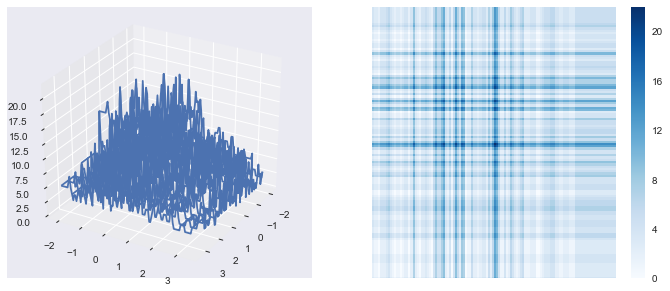

In [56]:
from mpl_toolkits.mplot3d import axes3d

lower_bound = max(x_z.min(),y_z.min()) # lower boundary of our param space
upper_bound = min(x_z.max(),y_z.max()) # upper boundary of our param space

# Initialising x- and y-dimensions of our param space
xx = np.linspace(lower_bound,upper_bound,num=120)
yy = np.linspace(lower_bound,upper_bound,num=120)
Z = np.empty([len(xx),len(yy)])
                    
# finding the cost over our param space (i.e., z-dimension)
print('Mapping parameter space...',end='')
for row,i in enumerate(xx):
    for col,j in enumerate(yy):
        Z[row,col] = split_cost(params=[i,j], minpercent=1, array=d) # cost over param space

print(' Done')

# Plotting x, y and z
%matplotlib inline
X = np.tile(xx,(120,1))
Y = np.tile(yy,(120,1))
Y = Y.T

fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.view_init(30,30)

ax = fig.add_subplot(122)
ax = ss.heatmap(Z, cmap="Blues", xticklabels=False, yticklabels=False)
pl.show()

The 3D left plot shows the parameter space in x, y and z dimensions. Cost is height (z-dimension). It is not a smooth function, but it may contain local minimum = 0. The right plot shows a 2D top-down view of the 3D plot - peaks are blue (highest cost > 20), valleys are white (lowest cost = 0). It looks there may be multiple points in our param space where there is zero cost. Let's see if we can find them!

In [66]:
from scipy.optimize import optimize
result = np.asarray([0,0])
result = result.reshape(1,2)
xdim = np.linspace(-1.28, 1.28, num=10)
ydim = np.linspace(-1.28, 1.28, num=10)
print('Searching parameter space...', end='')
for i in xdim:
    for j in ydim:
        minimum = optimize.fmin(split_cost, x0=([i,j]), disp=0)
        if split_cost(minimum) < 1 & (minimum[0] < minimum[1]):
            result = np.append(result,minimum.reshape(1,2), axis = 0)
print(' Done')

result
#minimum = optimize.fmin(split_cost,[6,8])

Searching parameter space... Done


array([[ 0.  ,  0.  ],
       [-1.05,  0.41],
       [-1.04,  0.84],
       [-0.73,  0.41],
       [ 0.85,  0.85],
       [ 0.85,  0.85]])

In [67]:
# Check one of the solutions:
print('Cost of -1.05 and 0.41 is',split_cost([-1.05, 0.41]),'\n')

# Convert to hours
print('Converting these z-scores back to hours, we have:')
hours = {'Act_low': round(-1.04*np.std(x) + np.mean(x),2)}
hours['PSQI_low'] = round(-1.04*np.std(y) + np.mean(y),2)
hours['Act_high'] = round(0.84*np.std(x) + np.mean(x),2)
hours['PSQI_high'] = round(0.84*np.std(y) + np.mean(x),2)
print('Thresholds for actigraph are', hours['Act_low'], 'and', hours['Act_high'],'hours')
print('Thresholds for PSQI are', hours['PSQI_low'], 'and', hours['PSQI_high'],'hours')

Cost of -1.05 and 0.41 is 0 

Converting these z-scores back to hours, we have:
Thresholds for actigraph are 6.08 and 7.45 hours
Thresholds for PSQI are 5.65 and 7.63 hours


### Conclusion
There are multiple divisions (in z-score units) which are equivalent between our two variables of interest: actigraph hours and self-report hours.